In [1]:
from tensorflow.keras.datasets import cifar100
import os
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import cifarEdgesModel
from convert_gray import load_img, class_dict, rotation_aug, generate_negative, random_shuffle
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Get Dataset

## Image preprocessing

**get labels**

In [2]:
(_, y_train), (_, y_val) = cifar100.load_data()
# x_train, x_val = x_train / 255.0, x_val / 255.0
y_train = y_train.T[0]
y_val =  y_val.T[0]

**load gradient images**

* CIFAR100 EDTER 32\*32 dataset can be download at [Google Drive](https://drive.google.com/file/d/1MGHuTibfnFH6g0hdDCL5jUISkWWaBLZr/view?usp=sharing). 


In [3]:
x_train_edter = load_img(r'F:\dataset\CIFAR100\cifar100_train_sobel_32',(50000,32,32,1))
x_val_edter = load_img(r'F:\dataset\CIFAR100\cifar100_val_sobel_32',(10000,32,32,1))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1634.76it/s]


**positive augmentation**

In [4]:
x_train_aug_1 = rotation_aug(x_train_edter)
x_val_aug_1 = rotation_aug(x_val_edter)
x_train_aug_2 = rotation_aug(x_train_aug_1)
x_val_aug_2 = rotation_aug(x_val_aug_1)
x_train_aug_3 = rotation_aug(x_train_aug_2)
x_val_aug_3 = rotation_aug(x_val_aug_2)

50000it [00:00, 76216.23it/s]
10000it [00:00, 75741.31it/s]
50000it [00:00, 76800.95it/s]
10000it [00:00, 76336.27it/s]
50000it [00:00, 76687.23it/s]
10000it [00:00, 75737.89it/s]


In [5]:
x_train_all = np.concatenate((x_train_edter,x_train_aug_1,x_train_aug_2,x_train_aug_3))
x_val_all = np.concatenate((x_val_edter,x_val_aug_1,x_val_aug_2,x_val_aug_3))
y_train_all = np.concatenate((y_train,y_train,y_train,y_train))
y_val_all = np.concatenate((y_val,y_val,y_val,y_val))
print('#positive edter train',len(x_train_all))
print('#positive edter validation',len(x_val_all))

#positive edter train 200000
#positive edter validation 40000


**negatives augmentation**

In [6]:
x_train_neg = generate_negative(x_train_edter)
x_val_neg = generate_negative(x_val_edter)

50000it [00:25, 1990.13it/s]
10000it [00:05, 1968.50it/s]


In [7]:
x_train_all = np.concatenate((x_train_all,x_train_neg))
x_val_all = np.concatenate((x_val_all,x_val_neg))
y_train_all = np.concatenate((y_train_all,np.ones(50000)*100))
y_val_all = np.concatenate((y_val_all,np.ones(10000)*100))
print('#total train img',len(x_train_all))
print('#total validation img',len(x_val_all))
print('#total train img',len(y_train_all))
print('#total validation img',len(y_val_all))

#total train img 250000
#total validation img 50000
#total train img 250000
#total validation img 50000


**random shuffle**

In [8]:
x_train_all, y_train_all = random_shuffle(x_train_all, y_train_all)
x_val_all, y_val_all = random_shuffle(x_val_all, y_val_all)

## Image Visualization

**visualize first 10 images**

label: cattle


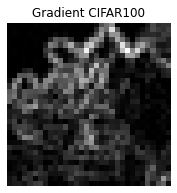

label: dinosaur


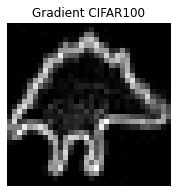

label: apple


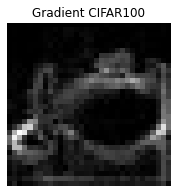

label: boy


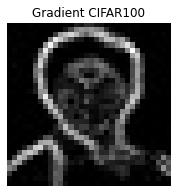

label: aquarium_fish


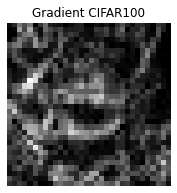

label: telephone


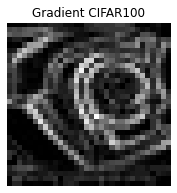

label: train


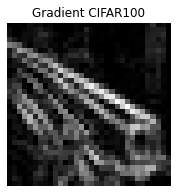

label: cup


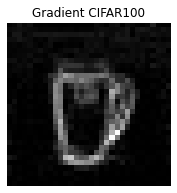

label: cloud


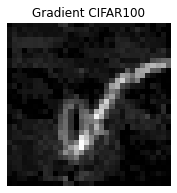

label: elephant


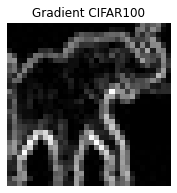

In [9]:
import matplotlib.pyplot as plt
for i in range(10):
    print('label: '+class_dict[int(y_train[i])])
    plt.figure(figsize=(3,3))
    plt.imshow(x_train_edter[i], cmap='gray')
    plt.title('Gradient CIFAR100')
    plt.axis('off')
    plt.show()

# Train Model

## load model

In [5]:
folder = 'lastest'
model = cifarEdgesModel.create_model(True, './weights/lastest/weights-improvement-06-2.19.h5')
# folder = 'simplecnn_edter'
# model = cifarEdgesModel.simple_cnn()

## compile model


In [7]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

## setting callbacks

Please mannually create `./weights` folder.

In [15]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
filepath = "./weights/"+folder+"/weights-improvement-{epoch:02d}-{loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
                             mode='max', save_weights_only=True)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True,
                                   write_images=False, update_freq='epoch', profile_batch=2,
                                   embeddings_freq=0, embeddings_metadata=None)

callbacks_list = [checkpoint, tensorboard_callback]                                               

## fit model

In [21]:
# train with colored-cifar100
# model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

# train with gradient-cifar100
model.fit(x_train_all, y_train_all, epochs=100, validation_data=(x_val_all, y_val_all), verbose=1, callbacks=callbacks_list)

Layer SubtractConstantLayer has arguments ['shape']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/100
7809/7813 [============================>.] - ETA: 0s - loss: 2.1978 - accuracy: 0.4512
Epoch 1: val_accuracy improved from 0.45648 to 0.45896, saving model to ./weights/lastest\weights-improvement-01-2.20.h5
7813/7813 [==============================] - 60s 8ms/step - loss: 2.1979 - accuracy: 0.4512 - val_loss: 2.1910 - val_accuracy: 0.4590
Epoch 2/100
7806/7813 [============================>.] - ETA: 0s - loss: 2.1988 - accuracy: 0.4516
Epoch 2: val_accuracy improved from 0.45896 to 0.45934, saving model to ./weights/lastest\

KeyboardInterrupt: 

## save weights

In [18]:
model.save_weights(f'./weights/{folder}/gradient_model.h5')

## model evaluation

In [8]:
model.evaluate(x_val_edter,  y_val, verbose=2)

313/313 - 6s - loss: 2.7274 - accuracy: 0.3241 - 6s/epoch - 21ms/step


[2.727428674697876, 0.32409998774528503]